# Compare performance of 4 CNNs on Chromebook 2

We compare **performance** of inference (forward propagation):

- of 4 different CNN **models** (net architecture + weights):
  - [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet);
  - [SqueezeNet 1.0](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.0);
  - [SqueezeNet 1.1](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1);
  - [GoogleNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet);

- with 4 different **libraries**:

  - [CPU] [OpenBLAS](https://github.com/xianyi/OpenBLAS) 0.2.18 (one thread per core);
  - [GPU] [clBLAS](https://github.com/clMathLibraries/clBLAS) 2.4 (OpenCL 1.1 compliant);
  - [GPU] [CLBlast](https://github.com/CNugteren/CLBlast) dev (35623cd > 0.8.0);
  - [GPU] [CLBlast](https://github.com/CNugteren/CLBlast) dev (35623cd > 0.8.0) with Mali-optimized [overlay](https://github.com/intelfx/CLBlast/tree/mali-overlay) (641bb07);
  
- on the [Samsung Chromebook 2](http://www.samsung.com/us/computing/chromebooks/under-12/samsung-chromebook-2-11-6-xe503c12-k01us/) **platform**:
  - [CPU] quad-core ARM Cortex-A15 @ 1900 MHz;
  - [GPU] quad-core ARM Mali-T628 @ 600 MHz;
  - [GPU] OpenCL driver 6.0 (r6p0);
  - [GPU] OpenCL standard 1.1;
  - [RAM] 2 GB;
  - Gentoo Linux [over](community.arm.com/groups/arm-mali-graphics/blog/2014/12/18/installing-opencl-on-chromebook-2-in-30-minutes) ChromeOS with `/etc/lsb-release`:
```
CHROMEOS_AUSERVER=https://tools.google.com/service/update2
CHROMEOS_BOARD_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_CANARY_APPID={90F229CE-83E2-4FAF-8479-E368A34938B1}
CHROMEOS_DEVSERVER=
CHROMEOS_RELEASE_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_RELEASE_BOARD=peach_pit-signed-mp-v2keys
CHROMEOS_RELEASE_BRANCH_NUMBER=68
CHROMEOS_RELEASE_BUILD_NUMBER=8350
CHROMEOS_RELEASE_BUILD_TYPE=Official Build
CHROMEOS_RELEASE_CHROME_MILESTONE=52
CHROMEOS_RELEASE_DESCRIPTION=8350.68.0 (Official Build) stable-channel peach_pit 
CHROMEOS_RELEASE_NAME=Chrome OS
CHROMEOS_RELEASE_PATCH_NUMBER=0
CHROMEOS_RELEASE_TRACK=stable-channel
CHROMEOS_RELEASE_VERSION=8350.68.0
DEVICETYPE=CHROMEBOOK
GOOGLE_RELEASE=8350.68.0
```

## Includes

### Collective Knowledge

In [1]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.7.4dev


### Scientific

In [2]:
import math
import IPython as ip
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mp

In [3]:
print ('IPython version: %s' % ip.__version__)
print ('NumPy version: %s' % np.__version__)
print ('SciPy version: %s' % sp.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 4.1.1
NumPy version: 1.10.4
SciPy version: 0.17.0
Pandas version: 0.18.0+57.g101d81d.dirty
Matplotlib version: 1.5.1


In [4]:
from matplotlib import cm
%matplotlib inline

## Access experimental results

In [5]:
def search_experimental_points_by_tags(tags):
    r=ck.access({'action':'get', 'module_uoa':'experiment', 'tags':tags, 'load_json_files':['0001']})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    # FIXME: For now, assume a single entry per the given tags.
    results = {}
    for point in r['points']:
            point_data_raw = point['0001']
            point_data_dict = {}
            time_fw_ms = [
                characteristics['run']['time_fw_ms'] 
                for characteristics in point_data_raw['characteristics_list']
                if characteristics['run']['run_success'] == 'yes'
            ]
            batch_size = point_data_raw['choices']['env']['CK_CAFFE_BATCH_SIZE']
            results[batch_size] = time_fw_ms
    return results

In [6]:
def get_min_time_per_image(results):
    df = pd.DataFrame(data=results)
    df.columns.name = 'Batch size'
    df.index.name = 'Repetition'
    df_stats = df.describe()
    min_time_per_image_idx = (df_stats.ix['mean'] / df.columns).idxmin()
    if not math.isnan(min_time_per_image_idx):
        mean = (df_stats[min_time_per_image_idx] / min_time_per_image_idx)['mean']
        std =  (df_stats[min_time_per_image_idx] / min_time_per_image_idx)['std']
        return (mean, std)
    else:
        return (None, None)

### AlexNet

In [7]:
alexnet_clblas_tags = 'chromebook2,time,caffemodel,alexnet,clblas'
alexnet_clblas_results = search_experimental_points_by_tags(alexnet_clblas_tags)
alexnet_clblas_min_time_per_image = get_min_time_per_image(alexnet_clblas_results)
alexnet_clblas_min_time_per_image

(535.13888888888891, 8.0335922042199481)

In [8]:
alexnet_clblast_development_tags = 'chromebook2,time,caffemodel,alexnet,clblast,vdevelopment'
alexnet_clblast_development_results = search_experimental_points_by_tags(alexnet_clblast_development_tags)
alexnet_clblast_development_min_time_per_image = get_min_time_per_image(alexnet_clblast_development_results)
alexnet_clblast_development_min_time_per_image

(565.09666666666669, 4.3450922122934852)

In [9]:
alexnet_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,alexnet,clblast,vmali-overlay'
alexnet_clblast_mali_overlay_results = search_experimental_points_by_tags(alexnet_clblast_mali_overlay_tags)
alexnet_clblast_mali_overlay_min_time_per_image = get_min_time_per_image(alexnet_clblast_mali_overlay_results)
alexnet_clblast_mali_overlay_min_time_per_image

(486.57500000000005, 20.60394066677539)

In [10]:
alexnet_openblas_tags = 'chromebook2,time,caffemodel,alexnet,openblas'
alexnet_openblas_results = search_experimental_points_by_tags(alexnet_openblas_tags)
alexnet_openblas_min_time_per_image = get_min_time_per_image(alexnet_openblas_results)
alexnet_openblas_min_time_per_image

(330.08333333333331, 25.476067854622574)

### SqueezeNet 1.0

In [11]:
squeezenet_1_0_clblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblas'
squeezenet_1_0_clblas_results = search_experimental_points_by_tags(squeezenet_1_0_clblas_tags)
squeezenet_1_0_clblas_min_time_per_image = get_min_time_per_image(squeezenet_1_0_clblas_results)
squeezenet_1_0_clblas_min_time_per_image

(665.42583333333334, 1.9714038990864458)

In [12]:
squeezenet_1_0_clblast_development_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblast,vdevelopment'
squeezenet_1_0_clblast_development_results = search_experimental_points_by_tags(squeezenet_1_0_clblast_development_tags)
squeezenet_1_0_clblast_development_min_time_per_image = get_min_time_per_image(squeezenet_1_0_clblast_development_results)
squeezenet_1_0_clblast_development_min_time_per_image

(617.96333333333325, 7.1004512767382133)

In [13]:
squeezenet_1_0_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblast,vmali-overlay'
squeezenet_1_0_clblast_mali_overlay_results = search_experimental_points_by_tags(squeezenet_1_0_clblast_mali_overlay_tags)
squeezenet_1_0_clblast_mali_overlay_min_time_per_image = get_min_time_per_image(squeezenet_1_0_clblast_mali_overlay_results)
squeezenet_1_0_clblast_mali_overlay_min_time_per_image

(499.44666666666672, 42.00408088639854)

In [14]:
squeezenet_1_0_openblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,openblas'
squeezenet_1_0_openblas_results = search_experimental_points_by_tags(squeezenet_1_0_openblas_tags)
squeezenet_1_0_openblas_min_time_per_image = get_min_time_per_image(squeezenet_1_0_openblas_results)
squeezenet_1_0_openblas_min_time_per_image

(275.07666666666665, 26.41040116286257)

### SqueezeNet 1.1

In [15]:
squeezenet_1_1_clblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblas'
squeezenet_1_1_clblas_results = search_experimental_points_by_tags(squeezenet_1_1_clblas_tags)
squeezenet_1_1_clblas_min_time_per_image = get_min_time_per_image(squeezenet_1_1_clblas_results)
squeezenet_1_1_clblas_min_time_per_image

(241.67033333333333, 0.95675089277895931)

In [16]:
squeezenet_1_1_clblast_development_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblast,vdevelopment'
squeezenet_1_1_clblast_development_results = search_experimental_points_by_tags(squeezenet_1_1_clblast_development_tags)
squeezenet_1_1_clblast_development_min_time_per_image = get_min_time_per_image(squeezenet_1_1_clblast_development_results)
squeezenet_1_1_clblast_development_min_time_per_image

(395.6583333333333, 6.4850589498734195)

In [17]:
squeezenet_1_1_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblast,vmali-overlay'
squeezenet_1_1_clblast_mali_overlay_results = search_experimental_points_by_tags(squeezenet_1_1_clblast_mali_overlay_tags)
squeezenet_1_1_clblast_mali_overlay_min_time_per_image = get_min_time_per_image(squeezenet_1_1_clblast_mali_overlay_results)
squeezenet_1_1_clblast_mali_overlay_min_time_per_image

(None, None)

In [18]:
squeezenet_1_1_openblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,openblas'
squeezenet_1_1_openblas_results = search_experimental_points_by_tags(squeezenet_1_1_openblas_tags)
squeezenet_1_1_openblas_min_time_per_image = get_min_time_per_image(squeezenet_1_1_openblas_results)
squeezenet_1_1_openblas_min_time_per_image

(139.79100000000003, 3.5545299003525086)

### GoogleNet

In [19]:
googlenet_clblas_tags = 'chromebook2,time,caffemodel,googlenet,clblas'
googlenet_clblas_results = search_experimental_points_by_tags(googlenet_clblas_tags)
googlenet_clblas_min_time_per_image = get_min_time_per_image(googlenet_clblas_results)
googlenet_clblas_min_time_per_image

(836.8649999999999, 6.8739303713377886)

In [20]:
googlenet_clblast_development_tags = 'chromebook2,time,caffemodel,googlenet,clblast,vdevelopment'
googlenet_clblast_development_results = search_experimental_points_by_tags(googlenet_clblast_development_tags)
googlenet_clblast_development_min_time_per_image = get_min_time_per_image(googlenet_clblast_development_results)
googlenet_clblast_development_min_time_per_image

(1105.7725, 24.338692959976285)

In [21]:
googlenet_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,googlenet,clblast,vmali-overlay'
googlenet_clblast_mali_overlay_results = search_experimental_points_by_tags(googlenet_clblast_mali_overlay_tags)
googlenet_clblast_mali_overlay_min_time_per_image = get_min_time_per_image(googlenet_clblast_mali_overlay_results)
googlenet_clblast_mali_overlay_min_time_per_image

(None, None)

In [22]:
googlenet_openblas_tags = 'chromebook2,time,caffemodel,googlenet,openblas'
googlenet_openblas_results = search_experimental_points_by_tags(googlenet_openblas_tags)
googlenet_openblas_min_time_per_image = get_min_time_per_image(googlenet_openblas_results)
googlenet_openblas_min_time_per_image

(652.70249999999999, 45.175774204765965)

## Data frame

In [23]:
def extract_by_component(idx):
    data = {
        'AlexNet' : {
            'OpenBLAS: v0.2.18'     : alexnet_openblas_min_time_per_image[idx],
            'clBLAS: v2.4'          : alexnet_clblas_min_time_per_image[idx],
            'CLBlast: development'  : alexnet_clblast_development_min_time_per_image[idx],
            'CLBlast: Mali overlay' : alexnet_clblast_mali_overlay_min_time_per_image[idx]
        },
        'SqueezeNet 1.0' : {
            'OpenBLAS: v0.2.18'     : squeezenet_1_0_openblas_min_time_per_image[idx],
            'clBLAS: v2.4'          : squeezenet_1_0_clblas_min_time_per_image[idx],
            'CLBlast: development'  : squeezenet_1_0_clblast_development_min_time_per_image[idx],
            'CLBlast: Mali overlay' : squeezenet_1_0_clblast_mali_overlay_min_time_per_image[idx]
        },
        'SqueezeNet 1.1' : {
            'OpenBLAS: v0.2.18'     : squeezenet_1_1_openblas_min_time_per_image[idx],
            'clBLAS: v2.4'          : squeezenet_1_1_clblas_min_time_per_image[idx],
            'CLBlast: development'  : squeezenet_1_1_clblast_development_min_time_per_image[idx],
            'CLBlast: Mali overlay' : squeezenet_1_1_clblast_mali_overlay_min_time_per_image[idx]
        },
        'GoogleNet' : {
            'OpenBLAS: v0.2.18'     : googlenet_openblas_min_time_per_image[idx],
            'clBLAS: v2.4'          : googlenet_clblas_min_time_per_image[idx],
            'CLBlast: development'  : googlenet_clblast_development_min_time_per_image[idx],
            'CLBlast: Mali overlay' : googlenet_clblast_mali_overlay_min_time_per_image[idx]
        },
    }
    return data

In [24]:
df_mean = pd.DataFrame(extract_by_component(0))
df_mean

,AlexNet,GoogleNet,SqueezeNet 1.0,SqueezeNet 1.1
CLBlast: Mali overlay,486.575000,NaN,499.446667,NaN
CLBlast: development,565.096667,1105.7725,617.963333,395.658333
OpenBLAS: v0.2.18,330.083333,652.7025,275.076667,139.791000
clBLAS: v2.4,535.138889,836.8650,665.425833,241.670333


In [25]:
df_std = pd.DataFrame(extract_by_component(1))
df_std

,AlexNet,GoogleNet,SqueezeNet 1.0,SqueezeNet 1.1
CLBlast: Mali overlay,20.603941,NaN,42.004081,NaN
CLBlast: development,4.345092,24.338693,7.100451,6.485059
OpenBLAS: v0.2.18,25.476068,45.175774,26.410401,3.554530
clBLAS: v2.4,8.033592,6.873930,1.971404,0.956751


## Plot

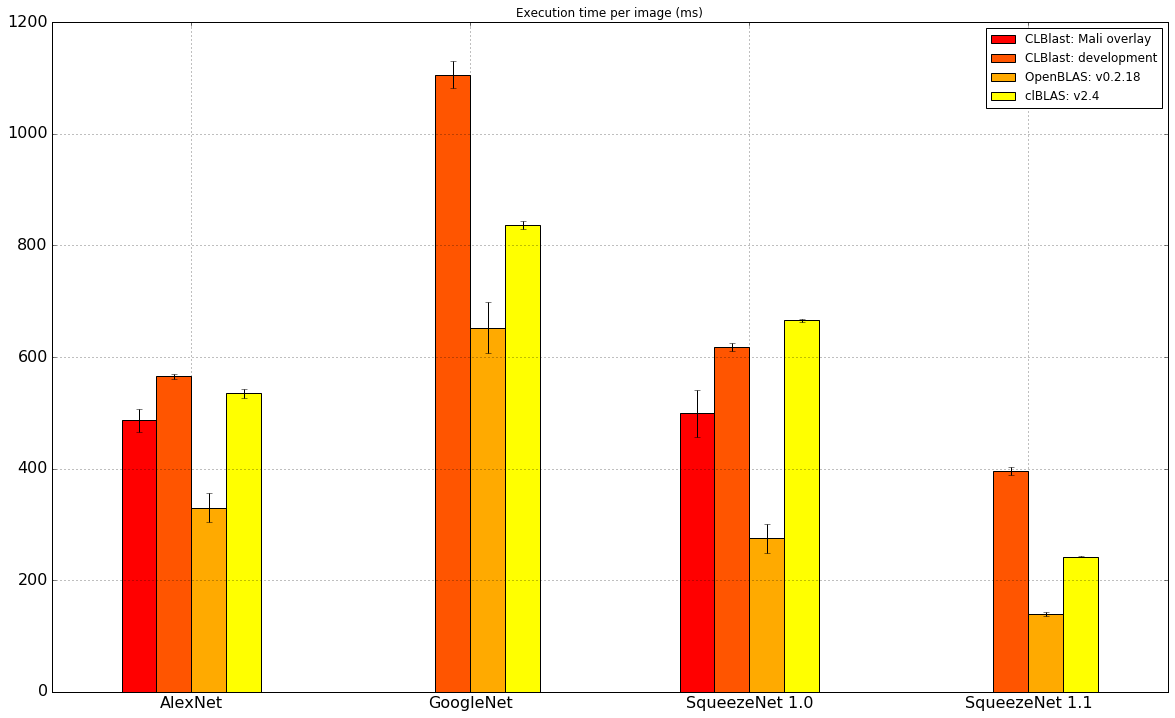

In [26]:
df_mean.T \
    .plot(yerr=df_std.T, title='Execution time per image (ms)',
          kind='bar', rot=0, ylim=[0,1200], figsize=[20, 12], grid=True, legend=True, colormap=cm.autumn, fontsize=16)

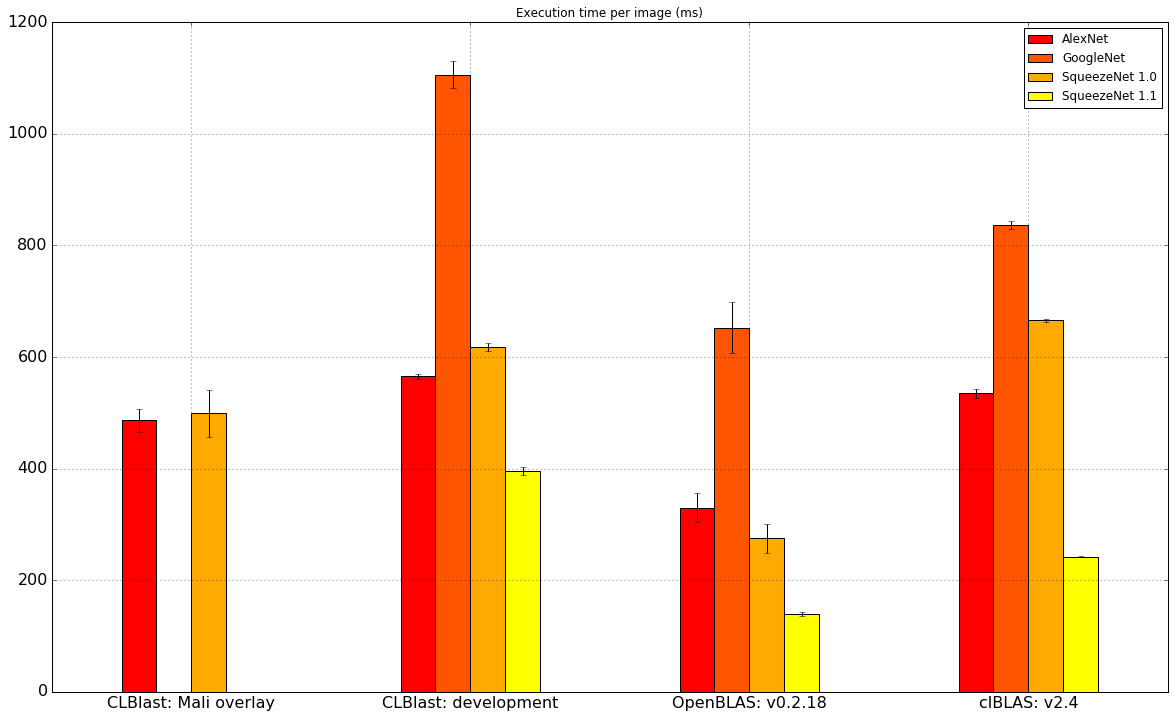

In [27]:
df_mean \
    .plot(yerr=df_std, title='Execution time per image (ms)',
          kind='bar', rot=0, ylim=[0,1200], figsize=[20, 12], grid=True, legend=True, colormap=cm.autumn, fontsize=16)